# Image Classification
In this project, I classify images from the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).  The dataset consists of airplanes, dogs, cats, and other objects. First I need to preprocess the images, then train a convolutional neural network on all the samples. The images need to be normalized and the labels need to be one-hot encoded.  I will get to apply what I have learned to build the convolutional, max pooling, dropout, and fully connected layers.  At the end, I will get to see the neural network's predictions on the sample images.
## Get the Data
Run the following cell to download the [CIFAR-10 dataset for python](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

In [2]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import problem_unittests as tests
import tarfile
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
cifar10_dataset_folder_path = 'cifar-10-batches-py'

# Use Floyd's cifar-10 dataset if present
floyd_cifar10_location = '/input/cifar-10/python.tar.gz'
if isfile(floyd_cifar10_location):
    tar_gz_path = floyd_cifar10_location
else:
    tar_gz_path = 'cifar-10-python.tar.gz'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(tar_gz_path):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            tar_gz_path,
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open(tar_gz_path) as tar:
        tar.extractall()
        tar.close()


tests.test_folder_path(cifar10_dataset_folder_path)

All files found!


## Explore the Data
The dataset is broken into batches to prevent your machine from running out of memory.  The CIFAR-10 dataset consists of 5 batches, named `data_batch_1`, `data_batch_2`, etc.. Each batch contains the labels and images that are one of the following:
* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck

Understanding a dataset is part of making predictions on the data.  Play around with the code cell below by changing the `batch_id` and `sample_id`. The `batch_id` is the id for a batch (1-5). The `sample_id` is the id for a image and label pair in the batch.


Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 8:
Image - Min Value: 8 Max Value: 252
Image - Shape: (32, 32, 3)
Label - Label Id: 8 Name: ship


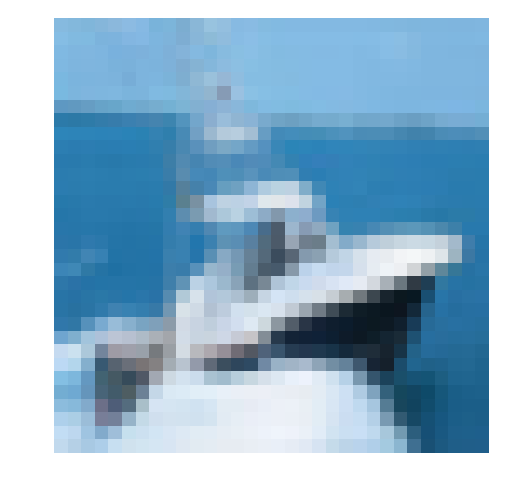

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np

# Explore the dataset
batch_id = 1
sample_id = 8
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## Implement Preprocess Functions
### Normalize
In the cell below, implement the `normalize` function to take in image data, `x`, and return it as a normalized Numpy array. The values should be in the range of 0 to 1, inclusive.  The return object should be the same shape as `x`.

In [3]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    x = x/255
    return x

tests.test_normalize(normalize)

Tests Passed


### One-hot encode
Implement the `one_hot_encode` function. The input, `x`, are a list of labels.  Implement the function to return the list of labels as One-Hot encoded Numpy array.  The possible values for labels are 0 to 9. The one-hot encoding function should return the same encoding for each value between each call to `one_hot_encode`. For this I use following function from sklearn:

### [sklearn.preprocessing.LabelBinarizer( )](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html)
<br>

In [4]:
from sklearn import preprocessing
Map = [0,1,2,3,4,5,6,7,8,9]

def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    # TODO: Implement Function     
    lb = preprocessing.LabelBinarizer()
    lb.fit(Map)
    return lb.transform(x)

tests.test_one_hot_encode(one_hot_encode)

Tests Passed


### Randomize Data
As you saw from exploring the data above, the order of the samples are randomized.  It doesn't hurt to randomize it again, but don't need to for this dataset.

## Preprocess all the data and save it
Following function will preprocess and save the input data, and the codes also use 10% of the training data for validation.

In [9]:
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

# Check Point
This is the first checkpoint.  If you ever decide to come back to this notebook or have to restart the notebook, you can start from here.  The preprocessed data has been saved to disk.

In [5]:
import pickle
import problem_unittests as tests
import helper

# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Build the network
For the neural network, I build each layer into a function.

>**Note:** The [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages is similar to Keras's and TFLearn's abstraction to layers, so it's easy to pickup. For example, instead of using the TF Layers version of the `conv2d` class, [tf.layers.conv2d](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d), you would want to use the TF Neural Network version of `conv2d`, [tf.nn.conv2d](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d). 

Let's begin!

### Input
The neural network needs to read the image data, one-hot encoded labels, and dropout keep probability. Implement the following functions
* Implement `neural_net_image_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)
 * Set the shape using `image_shape` with batch size set to `None`.
 * Name the TensorFlow placeholder "x" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).
* Implement `neural_net_label_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)
 * Set the shape using `n_classes` with batch size set to `None`.
 * Name the TensorFlow placeholder "y" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).
* Implement `neural_net_keep_prob_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder) for dropout keep probability.
 * Name the TensorFlow placeholder "keep_prob" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).

These names will be used at the end of the project to load your saved model.

Note: `None` for shapes in TensorFlow allow for a dynamic size.

In [6]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a batch of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    image_input = tf.placeholder(tf.float32, shape=(None, image_shape[0], image_shape[1], image_shape[2]),\
                                 name='x')
    return image_input


def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    label_input = tf.placeholder(tf.int32, shape=(None, n_classes),\
                                 name='y')
    return label_input


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    keep_prob = tf.placeholder(tf.float32,name='keep_prob')
    return keep_prob


tf.reset_default_graph()
tests.test_nn_image_inputs(neural_net_image_input)
tests.test_nn_label_inputs(neural_net_label_input)
tests.test_nn_keep_prob_inputs(neural_net_keep_prob_input)

Image Input Tests Passed.
Label Input Tests Passed.
Keep Prob Tests Passed.


### Convolution and Max Pooling Layer
Convolution layers have a lot of success with images:
* Create the weight and bias using `conv_ksize`, `conv_num_outputs` and the shape of `x_tensor`.
* Apply a convolution to `x_tensor` using weight and `conv_strides`.
 * The same padding is recommended.
* Add bias
* Add a nonlinear activation to the convolution.
* Apply Max Pooling using `pool_ksize` and `pool_strides`.

In [7]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides, train=True):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    # set weight (filter)
    # print([conv_ksize[0],conv_ksize[1],x_tensor.get_shape().as_list()[3],conv_num_outputs])
    weight = tf.Variable(tf.truncated_normal([conv_ksize[0],conv_ksize[1],\
                         x_tensor.get_shape().as_list()[3], conv_num_outputs], stddev=0.03),\
                         name='conv_weights')
    
    # set bias
#     bias = tf.Variable(tf.truncated_normal([conv_num_outputs], stddev=0.1), name='conv_bias')
    bias = tf.Variable(tf.zeros(conv_num_outputs))
    
    # set strides of conv2d
    stride = [1, conv_strides[0], conv_strides[1], 1]
    
    # conv2d
    conv2d = tf.nn.bias_add(tf.nn.conv2d(x_tensor, weight, stride, padding='SAME'),\
                   bias)
    
    # add activation function
    conv2d = tf.nn.relu(conv2d)
    
    # add BN
    bn_conv2d = tf.layers.batch_normalization(conv2d, axis=-1, momentum=0.99, epsilon=0.001, center=True, 
                                              scale=True, training=train)
    
    # add Max pooling
    conv2d_maxpool = tf.nn.max_pool(bn_conv2d, [1,pool_ksize[0],pool_ksize[1],1],\
                                    [1,pool_strides[0],pool_strides[1],1], padding='SAME')
    return conv2d_maxpool 


tests.test_con_pool(conv2d_maxpool)

Tests Passed


### Flatten Layer
Implement the `flatten` function to change the dimension of `x_tensor` from a 4-D tensor to a 2-D tensor.  The output should be the shape (*Batch Size*, *Flattened Image Size*). 

In [8]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    # "-1" represents "None", so use -1 when the batch_size is None
    x_tensor = tf.reshape(x_tensor, [-1, x_tensor.get_shape().as_list()[1]*x_tensor.get_shape().as_list()[2]*\
                                     x_tensor.get_shape().as_list()[3]])
    return x_tensor


tests.test_flatten(flatten)

Tests Passed


### Fully-Connected Layer
Implement the `fully_conn` function to apply a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*).

In [9]:
def fully_conn(x_tensor, num_outputs, train=True):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # set fully_connected layer weights
    weight = tf.Variable(tf.truncated_normal([x_tensor.get_shape().as_list()[1],num_outputs], stddev=0.05),\
                         name='conv2full_weights')
    
    # set fully_connected layer weights
    bias = tf.Variable(tf.zeros(num_outputs), name='conv2full_bias')
    # fully connect between conv layer and fully connected layer
    full_output = tf.add(tf.matmul(x_tensor,weight), bias)
    
    # add relu
    full_output = tf.nn.relu(full_output)
    
    # add BN
    bn_output = tf.layers.batch_normalization(full_output, axis=-1, momentum=0.99, epsilon=0.001, center=True, 
                                              scale=True, training=train)
    return bn_output


# tests.test_fully_conn(fully_conn)

### Output Layer
Implement the `output` function to apply a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*).

In [10]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # set fully_connected layer weights
    weight = tf.Variable(tf.truncated_normal([x_tensor.get_shape().as_list()[1],num_outputs], stddev=0.05),\
                         name='full2output_weights')
    
    # set fully_connected layer weights
    bias = tf.Variable(tf.zeros(num_outputs), name='full2output_bias')
    # fully connect between conv layer and fully connected layer
    final_output = tf.add(tf.matmul(x_tensor,weight), bias)
    return final_output


tests.test_output(output)

Tests Passed


### Create Convolutional Model
Implement the function `conv_net` to create a convolutional neural network model. The function takes in a batch of images, `x`, and outputs logits:

* Apply 1, 2, or 3 Convolution and Max Pool layers
* Apply a Flatten Layer
* Apply 1, 2, or 3 Fully Connected Layers
* Apply an Output Layer
* Return the output
* Apply [TensorFlow's Dropout](https://www.tensorflow.org/api_docs/python/tf/nn/dropout) to one or more layers in the model using `keep_prob`. 

In [40]:
def conv_net(x, keep_prob, conv_num_outputs = [40,80,160], conv_ksize = (3,3), conv_strides = (1,1), pool_ksize = (2,2),
    pool_strides = (2,2), output_units=[512, 128], train_or_not=True):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    #    Play around with different number of outputs, kernel size and stride
    # Function Definition from Above:
    #    conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)

    conv2d_Layer1 = conv2d_maxpool(x, conv_num_outputs[0], conv_ksize, conv_strides, pool_ksize, pool_strides, train=train_or_not)
    conv2d_Layer2 = conv2d_maxpool(conv2d_Layer1, conv_num_outputs[1], conv_ksize, conv_strides, pool_ksize, pool_strides, train=train_or_not)
    conv2d_Layer3 = conv2d_maxpool(conv2d_Layer2, conv_num_outputs[2], conv_ksize, conv_strides, pool_ksize, pool_strides, train=train_or_not)
    
    # Function Definition from Above:
    #   flatten(x_tensor)
    flatten_Layer = flatten(conv2d_Layer3)

    #    Play around with different number of outputs
    # Function Definition from Above:
    #   fully_conn(x_tensor, num_outputs)
    full_Layer1 = fully_conn(flatten_Layer, output_units[0], train=train_or_not)
    full_Layer1 = tf.nn.dropout(full_Layer1, keep_prob)
    
    full_Layer2 = fully_conn(full_Layer1, output_units[1], train=train_or_not)
    full_Layer2 = tf.nn.dropout(full_Layer2, keep_prob)
    #    Set this to the number of classes
    # Function Definition from Above:
    #   output(x_tensor, num_outputs)
    output_Layer = output(full_Layer2, 10)
    
    return output_Layer





##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob, conv_num_outputs = [64,150,280], conv_ksize = (3,3), conv_strides = (1,1), pool_ksize = (2,2),
                  pool_strides = (2,2), output_units=[1024, 128], train_or_not=True)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

tests.test_conv_net(conv_net)

Neural Network Built!


## Train the Neural Network
### Single Optimization
Implement the function `train_neural_network` to do a single optimization.  The optimization should use `optimizer` to optimize in `session` with a `feed_dict` of the following:
* `x` for image input
* `y` for labels
* `keep_prob` for keep probability for dropout

This function will be called for each batch, so `tf.global_variables_initializer()` has already been called.

In [32]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    session.run(optimizer, feed_dict={x:feature_batch, y:label_batch,\
                                       keep_prob:keep_probability})
    pass



tests.test_train_nn(train_neural_network)

Tests Passed


### Show Stats
Implement the function `print_stats` to print loss and validation accuracy.  Use the global variables `valid_features` and `valid_labels` to calculate validation accuracy.  Use a keep probability of `1.0` to calculate the loss and validation accuracy.

In [33]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    loss = session.run(cost, feed_dict={x:feature_batch, y:label_batch, keep_prob:1.0})
    Accuracy = session.run(accuracy, feed_dict={x:valid_features, y:valid_labels, keep_prob:1.0 })
    print('Training loss: {:.4f}... '.format(loss),
                  'Accuracy: {:.4f}...'.format((Accuracy)))
    pass

### Hyperparameters
Tune the following parameters:
* Set `epochs` to the number of iterations until the network stops learning or start overfitting
* Set `batch_size` to the highest number that your machine has memory for. common sizes are:
 * 64
 * 128
 * 256
 * ...
* Set `keep_probability` to the probability of keeping a node using dropout

In [19]:
epochs = 50
batch_size = 128
keep_probability = 0.5

### Train on a Single CIFAR-10 Batch
Instead of training the neural network on all the CIFAR-10 batches of data, let's use a single batch. This should save time while you iterate on the model to get the relatively best parameters. 

In [41]:
print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

Checking the Training on a Single Batch...
Epoch  1, CIFAR-10 Batch 1:  Training loss: 1.6096...  Accuracy: 0.4914...
Epoch  2, CIFAR-10 Batch 1:  Training loss: 1.1826...  Accuracy: 0.5390...
Epoch  3, CIFAR-10 Batch 1:  Training loss: 0.9442...  Accuracy: 0.5712...
Epoch  4, CIFAR-10 Batch 1:  Training loss: 0.6594...  Accuracy: 0.6062...
Epoch  5, CIFAR-10 Batch 1:  Training loss: 0.5133...  Accuracy: 0.6242...
Epoch  6, CIFAR-10 Batch 1:  Training loss: 0.3672...  Accuracy: 0.6394...
Epoch  7, CIFAR-10 Batch 1:  Training loss: 0.2278...  Accuracy: 0.6434...
Epoch  8, CIFAR-10 Batch 1:  Training loss: 0.1833...  Accuracy: 0.6470...
Epoch  9, CIFAR-10 Batch 1:  Training loss: 0.0706...  Accuracy: 0.6446...
Epoch 10, CIFAR-10 Batch 1:  Training loss: 0.0582...  Accuracy: 0.6396...
Epoch 11, CIFAR-10 Batch 1:  Training loss: 0.0489...  Accuracy: 0.6434...
Epoch 12, CIFAR-10 Batch 1:  Training loss: 0.0246...  Accuracy: 0.6548...
Epoch 13, CIFAR-10 Batch 1:  Training loss: 0.0195...  Ac

### Fully Train the Model
Now that you got a good accuracy with a single CIFAR-10 batch, try it with all five batches.

In [41]:
epochs = 300
batch_size = 256
keep_probability = 0.5

In [42]:
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  Training loss: 1.5085...  Accuracy: 0.4844...
Epoch  1, CIFAR-10 Batch 2:  Training loss: 1.0895...  Accuracy: 0.5298...
Epoch  1, CIFAR-10 Batch 3:  Training loss: 0.9092...  Accuracy: 0.5684...
Epoch  1, CIFAR-10 Batch 4:  Training loss: 0.8501...  Accuracy: 0.6132...
Epoch  1, CIFAR-10 Batch 5:  Training loss: 0.7342...  Accuracy: 0.6392...
Epoch  2, CIFAR-10 Batch 1:  Training loss: 0.8188...  Accuracy: 0.6576...
Epoch  2, CIFAR-10 Batch 2:  Training loss: 0.7106...  Accuracy: 0.6880...
Epoch  2, CIFAR-10 Batch 3:  Training loss: 0.4360...  Accuracy: 0.6838...
Epoch  2, CIFAR-10 Batch 4:  Training loss: 0.4852...  Accuracy: 0.7128...
Epoch  2, CIFAR-10 Batch 5:  Training loss: 0.3554...  Accuracy: 0.7154...
Epoch  3, CIFAR-10 Batch 1:  Training loss: 0.4355...  Accuracy: 0.7368...
Epoch  3, CIFAR-10 Batch 2:  Training loss: 0.4232...  Accuracy: 0.7364...
Epoch  3, CIFAR-10 Batch 3:  Training loss: 0.2367...  Accuracy: 0.7414...
Epoch  3, CIF

Epoch 22, CIFAR-10 Batch 5:  Training loss: 0.0002...  Accuracy: 0.8010...
Epoch 23, CIFAR-10 Batch 1:  Training loss: 0.0003...  Accuracy: 0.8014...
Epoch 23, CIFAR-10 Batch 2:  Training loss: 0.0001...  Accuracy: 0.8046...
Epoch 23, CIFAR-10 Batch 3:  Training loss: 0.0027...  Accuracy: 0.7990...
Epoch 23, CIFAR-10 Batch 4:  Training loss: 0.0002...  Accuracy: 0.8006...
Epoch 23, CIFAR-10 Batch 5:  Training loss: 0.0005...  Accuracy: 0.8002...
Epoch 24, CIFAR-10 Batch 1:  Training loss: 0.0002...  Accuracy: 0.8030...
Epoch 24, CIFAR-10 Batch 2:  Training loss: 0.0001...  Accuracy: 0.8028...
Epoch 24, CIFAR-10 Batch 3:  Training loss: 0.0003...  Accuracy: 0.8110...
Epoch 24, CIFAR-10 Batch 4:  Training loss: 0.0001...  Accuracy: 0.8004...
Epoch 24, CIFAR-10 Batch 5:  Training loss: 0.0001...  Accuracy: 0.8016...
Epoch 25, CIFAR-10 Batch 1:  Training loss: 0.0004...  Accuracy: 0.7978...
Epoch 25, CIFAR-10 Batch 2:  Training loss: 0.0001...  Accuracy: 0.7954...
Epoch 25, CIFAR-10 Batch 

Epoch 44, CIFAR-10 Batch 4:  Training loss: 0.0000...  Accuracy: 0.8056...
Epoch 44, CIFAR-10 Batch 5:  Training loss: 0.0000...  Accuracy: 0.8114...
Epoch 45, CIFAR-10 Batch 1:  Training loss: 0.0001...  Accuracy: 0.8026...
Epoch 45, CIFAR-10 Batch 2:  Training loss: 0.0001...  Accuracy: 0.8090...
Epoch 45, CIFAR-10 Batch 3:  Training loss: 0.0000...  Accuracy: 0.8078...
Epoch 45, CIFAR-10 Batch 4:  Training loss: 0.0003...  Accuracy: 0.7956...
Epoch 45, CIFAR-10 Batch 5:  Training loss: 0.0001...  Accuracy: 0.8096...
Epoch 46, CIFAR-10 Batch 1:  Training loss: 0.0000...  Accuracy: 0.7982...
Epoch 46, CIFAR-10 Batch 2:  Training loss: 0.0000...  Accuracy: 0.8000...
Epoch 46, CIFAR-10 Batch 3:  Training loss: 0.0001...  Accuracy: 0.8010...
Epoch 46, CIFAR-10 Batch 4:  Training loss: 0.0000...  Accuracy: 0.8002...
Epoch 46, CIFAR-10 Batch 5:  Training loss: 0.0001...  Accuracy: 0.8012...
Epoch 47, CIFAR-10 Batch 1:  Training loss: 0.0000...  Accuracy: 0.7952...
Epoch 47, CIFAR-10 Batch 

Epoch 66, CIFAR-10 Batch 3:  Training loss: 0.0000...  Accuracy: 0.8076...
Epoch 66, CIFAR-10 Batch 4:  Training loss: 0.0000...  Accuracy: 0.8126...
Epoch 66, CIFAR-10 Batch 5:  Training loss: 0.0001...  Accuracy: 0.8116...
Epoch 67, CIFAR-10 Batch 1:  Training loss: 0.0000...  Accuracy: 0.8024...
Epoch 67, CIFAR-10 Batch 2:  Training loss: 0.0001...  Accuracy: 0.8062...
Epoch 67, CIFAR-10 Batch 3:  Training loss: 0.0000...  Accuracy: 0.8020...
Epoch 67, CIFAR-10 Batch 4:  Training loss: 0.0000...  Accuracy: 0.8046...
Epoch 67, CIFAR-10 Batch 5:  Training loss: 0.0000...  Accuracy: 0.8070...
Epoch 68, CIFAR-10 Batch 1:  Training loss: 0.0000...  Accuracy: 0.8040...
Epoch 68, CIFAR-10 Batch 2:  Training loss: 0.0000...  Accuracy: 0.8056...
Epoch 68, CIFAR-10 Batch 3:  Training loss: 0.0000...  Accuracy: 0.8054...
Epoch 68, CIFAR-10 Batch 4:  Training loss: 0.0000...  Accuracy: 0.8092...
Epoch 68, CIFAR-10 Batch 5:  Training loss: 0.0000...  Accuracy: 0.8106...
Epoch 69, CIFAR-10 Batch 

Epoch 88, CIFAR-10 Batch 2:  Training loss: 0.0000...  Accuracy: 0.8068...
Epoch 88, CIFAR-10 Batch 3:  Training loss: 0.0000...  Accuracy: 0.8048...
Epoch 88, CIFAR-10 Batch 4:  Training loss: 0.0000...  Accuracy: 0.8048...
Epoch 88, CIFAR-10 Batch 5:  Training loss: 0.0000...  Accuracy: 0.8098...
Epoch 89, CIFAR-10 Batch 1:  Training loss: 0.0000...  Accuracy: 0.8102...
Epoch 89, CIFAR-10 Batch 2:  Training loss: 0.0000...  Accuracy: 0.8042...
Epoch 89, CIFAR-10 Batch 3:  Training loss: 0.0000...  Accuracy: 0.8076...
Epoch 89, CIFAR-10 Batch 4:  Training loss: 0.0001...  Accuracy: 0.8038...
Epoch 89, CIFAR-10 Batch 5:  Training loss: 0.0000...  Accuracy: 0.8082...
Epoch 90, CIFAR-10 Batch 1:  Training loss: 0.0000...  Accuracy: 0.8014...
Epoch 90, CIFAR-10 Batch 2:  Training loss: 0.0000...  Accuracy: 0.8046...
Epoch 90, CIFAR-10 Batch 3:  Training loss: 0.0000...  Accuracy: 0.8054...
Epoch 90, CIFAR-10 Batch 4:  Training loss: 0.0000...  Accuracy: 0.8036...
Epoch 90, CIFAR-10 Batch 

Epoch 109, CIFAR-10 Batch 5:  Training loss: 0.0000...  Accuracy: 0.8056...
Epoch 110, CIFAR-10 Batch 1:  Training loss: 0.0000...  Accuracy: 0.8064...
Epoch 110, CIFAR-10 Batch 2:  Training loss: 0.0001...  Accuracy: 0.8060...
Epoch 110, CIFAR-10 Batch 3:  Training loss: 0.0000...  Accuracy: 0.8110...
Epoch 110, CIFAR-10 Batch 4:  Training loss: 0.0000...  Accuracy: 0.8030...
Epoch 110, CIFAR-10 Batch 5:  Training loss: 0.0000...  Accuracy: 0.8096...
Epoch 111, CIFAR-10 Batch 1:  Training loss: 0.0000...  Accuracy: 0.8072...
Epoch 111, CIFAR-10 Batch 2:  Training loss: 0.0000...  Accuracy: 0.8102...
Epoch 111, CIFAR-10 Batch 3:  Training loss: 0.0000...  Accuracy: 0.8070...
Epoch 111, CIFAR-10 Batch 4:  Training loss: 0.0000...  Accuracy: 0.8120...
Epoch 111, CIFAR-10 Batch 5:  Training loss: 0.0000...  Accuracy: 0.8170...
Epoch 112, CIFAR-10 Batch 1:  Training loss: 0.0005...  Accuracy: 0.8084...
Epoch 112, CIFAR-10 Batch 2:  Training loss: 0.0000...  Accuracy: 0.8122...
Epoch 112, C

Epoch 131, CIFAR-10 Batch 2:  Training loss: 0.0000...  Accuracy: 0.8074...
Epoch 131, CIFAR-10 Batch 3:  Training loss: 0.0000...  Accuracy: 0.8056...
Epoch 131, CIFAR-10 Batch 4:  Training loss: 0.0000...  Accuracy: 0.8054...
Epoch 131, CIFAR-10 Batch 5:  Training loss: 0.0000...  Accuracy: 0.8132...
Epoch 132, CIFAR-10 Batch 1:  Training loss: 0.0000...  Accuracy: 0.8068...
Epoch 132, CIFAR-10 Batch 2:  Training loss: 0.0000...  Accuracy: 0.8092...
Epoch 132, CIFAR-10 Batch 3:  Training loss: 0.0000...  Accuracy: 0.8106...
Epoch 132, CIFAR-10 Batch 4:  Training loss: 0.0000...  Accuracy: 0.8148...
Epoch 132, CIFAR-10 Batch 5:  Training loss: 0.0000...  Accuracy: 0.8092...
Epoch 133, CIFAR-10 Batch 1:  Training loss: 0.0000...  Accuracy: 0.8078...
Epoch 133, CIFAR-10 Batch 2:  Training loss: 0.0000...  Accuracy: 0.8104...
Epoch 133, CIFAR-10 Batch 3:  Training loss: 0.0000...  Accuracy: 0.8104...
Epoch 133, CIFAR-10 Batch 4:  Training loss: 0.0000...  Accuracy: 0.8038...
Epoch 133, C

Epoch 152, CIFAR-10 Batch 4:  Training loss: 0.0000...  Accuracy: 0.8072...
Epoch 152, CIFAR-10 Batch 5:  Training loss: 0.0000...  Accuracy: 0.8066...
Epoch 153, CIFAR-10 Batch 1:  Training loss: 0.0000...  Accuracy: 0.8154...
Epoch 153, CIFAR-10 Batch 2:  Training loss: 0.0000...  Accuracy: 0.8120...
Epoch 153, CIFAR-10 Batch 3:  Training loss: 0.0000...  Accuracy: 0.8130...
Epoch 153, CIFAR-10 Batch 4:  Training loss: 0.0000...  Accuracy: 0.8164...
Epoch 153, CIFAR-10 Batch 5:  Training loss: 0.0000...  Accuracy: 0.8138...
Epoch 154, CIFAR-10 Batch 1:  Training loss: 0.0000...  Accuracy: 0.8108...
Epoch 154, CIFAR-10 Batch 2:  Training loss: 0.0000...  Accuracy: 0.8110...
Epoch 154, CIFAR-10 Batch 3:  Training loss: 0.0000...  Accuracy: 0.8122...
Epoch 154, CIFAR-10 Batch 4:  Training loss: 0.0003...  Accuracy: 0.8118...
Epoch 154, CIFAR-10 Batch 5:  Training loss: 0.0000...  Accuracy: 0.8078...
Epoch 155, CIFAR-10 Batch 1:  Training loss: 0.0000...  Accuracy: 0.8114...
Epoch 155, C

Epoch 174, CIFAR-10 Batch 1:  Training loss: 0.0000...  Accuracy: 0.8090...
Epoch 174, CIFAR-10 Batch 2:  Training loss: 0.0000...  Accuracy: 0.8112...
Epoch 174, CIFAR-10 Batch 3:  Training loss: 0.0000...  Accuracy: 0.8104...
Epoch 174, CIFAR-10 Batch 4:  Training loss: 0.0000...  Accuracy: 0.8026...
Epoch 174, CIFAR-10 Batch 5:  Training loss: 0.0000...  Accuracy: 0.8056...
Epoch 175, CIFAR-10 Batch 1:  Training loss: 0.0000...  Accuracy: 0.8098...
Epoch 175, CIFAR-10 Batch 2:  Training loss: 0.0000...  Accuracy: 0.8120...
Epoch 175, CIFAR-10 Batch 3:  Training loss: 0.0000...  Accuracy: 0.8078...
Epoch 175, CIFAR-10 Batch 4:  Training loss: 0.0000...  Accuracy: 0.8058...
Epoch 175, CIFAR-10 Batch 5:  Training loss: 0.0000...  Accuracy: 0.8116...
Epoch 176, CIFAR-10 Batch 1:  Training loss: 0.0000...  Accuracy: 0.8148...
Epoch 176, CIFAR-10 Batch 2:  Training loss: 0.0000...  Accuracy: 0.8100...
Epoch 176, CIFAR-10 Batch 3:  Training loss: 0.0000...  Accuracy: 0.8104...
Epoch 176, C

Epoch 195, CIFAR-10 Batch 3:  Training loss: 0.0000...  Accuracy: 0.8094...
Epoch 195, CIFAR-10 Batch 4:  Training loss: 0.0000...  Accuracy: 0.8130...
Epoch 195, CIFAR-10 Batch 5:  Training loss: 0.0000...  Accuracy: 0.8140...
Epoch 196, CIFAR-10 Batch 1:  Training loss: 0.0000...  Accuracy: 0.8122...
Epoch 196, CIFAR-10 Batch 2:  Training loss: 0.0000...  Accuracy: 0.8104...
Epoch 196, CIFAR-10 Batch 3:  Training loss: 0.0000...  Accuracy: 0.8050...
Epoch 196, CIFAR-10 Batch 4:  Training loss: 0.0000...  Accuracy: 0.8080...
Epoch 196, CIFAR-10 Batch 5:  Training loss: 0.0000...  Accuracy: 0.8114...
Epoch 197, CIFAR-10 Batch 1:  Training loss: 0.0000...  Accuracy: 0.8088...
Epoch 197, CIFAR-10 Batch 2:  Training loss: 0.0000...  Accuracy: 0.8068...
Epoch 197, CIFAR-10 Batch 3:  Training loss: 0.0000...  Accuracy: 0.8064...
Epoch 197, CIFAR-10 Batch 4:  Training loss: 0.0000...  Accuracy: 0.8094...
Epoch 197, CIFAR-10 Batch 5:  Training loss: 0.0000...  Accuracy: 0.8120...
Epoch 198, C

Epoch 216, CIFAR-10 Batch 5:  Training loss: 0.0000...  Accuracy: 0.8084...
Epoch 217, CIFAR-10 Batch 1:  Training loss: 0.0000...  Accuracy: 0.8136...
Epoch 217, CIFAR-10 Batch 2:  Training loss: 0.0000...  Accuracy: 0.8148...
Epoch 217, CIFAR-10 Batch 3:  Training loss: 0.0000...  Accuracy: 0.8148...
Epoch 217, CIFAR-10 Batch 4:  Training loss: 0.0000...  Accuracy: 0.8124...
Epoch 217, CIFAR-10 Batch 5:  Training loss: 0.0000...  Accuracy: 0.8078...
Epoch 218, CIFAR-10 Batch 1:  Training loss: 0.0000...  Accuracy: 0.8126...
Epoch 218, CIFAR-10 Batch 2:  Training loss: 0.0000...  Accuracy: 0.8134...
Epoch 218, CIFAR-10 Batch 3:  Training loss: 0.0000...  Accuracy: 0.8092...
Epoch 218, CIFAR-10 Batch 4:  Training loss: 0.0000...  Accuracy: 0.8126...
Epoch 218, CIFAR-10 Batch 5:  Training loss: 0.0000...  Accuracy: 0.8130...
Epoch 219, CIFAR-10 Batch 1:  Training loss: 0.0000...  Accuracy: 0.8142...
Epoch 219, CIFAR-10 Batch 2:  Training loss: 0.0000...  Accuracy: 0.8134...
Epoch 219, C

Epoch 238, CIFAR-10 Batch 2:  Training loss: 0.0000...  Accuracy: 0.8086...
Epoch 238, CIFAR-10 Batch 3:  Training loss: 0.0000...  Accuracy: 0.8116...
Epoch 238, CIFAR-10 Batch 4:  Training loss: 0.0000...  Accuracy: 0.8106...
Epoch 238, CIFAR-10 Batch 5:  Training loss: 0.0000...  Accuracy: 0.8078...
Epoch 239, CIFAR-10 Batch 1:  Training loss: 0.0000...  Accuracy: 0.8132...
Epoch 239, CIFAR-10 Batch 2:  Training loss: 0.0000...  Accuracy: 0.8104...
Epoch 239, CIFAR-10 Batch 3:  Training loss: 0.0000...  Accuracy: 0.8128...
Epoch 239, CIFAR-10 Batch 4:  Training loss: 0.0001...  Accuracy: 0.8154...
Epoch 239, CIFAR-10 Batch 5:  Training loss: 0.0000...  Accuracy: 0.8138...
Epoch 240, CIFAR-10 Batch 1:  Training loss: 0.0000...  Accuracy: 0.8136...
Epoch 240, CIFAR-10 Batch 2:  Training loss: 0.0000...  Accuracy: 0.8106...
Epoch 240, CIFAR-10 Batch 3:  Training loss: 0.0000...  Accuracy: 0.8152...
Epoch 240, CIFAR-10 Batch 4:  Training loss: 0.0000...  Accuracy: 0.8122...
Epoch 240, C

Epoch 259, CIFAR-10 Batch 4:  Training loss: 0.0000...  Accuracy: 0.8176...
Epoch 259, CIFAR-10 Batch 5:  Training loss: 0.0000...  Accuracy: 0.8142...
Epoch 260, CIFAR-10 Batch 1:  Training loss: 0.0000...  Accuracy: 0.8140...
Epoch 260, CIFAR-10 Batch 2:  Training loss: 0.0000...  Accuracy: 0.8146...
Epoch 260, CIFAR-10 Batch 3:  Training loss: 0.0000...  Accuracy: 0.8102...
Epoch 260, CIFAR-10 Batch 4:  Training loss: 0.0000...  Accuracy: 0.8142...
Epoch 260, CIFAR-10 Batch 5:  Training loss: 0.0000...  Accuracy: 0.8188...
Epoch 261, CIFAR-10 Batch 1:  Training loss: 0.0000...  Accuracy: 0.8152...
Epoch 261, CIFAR-10 Batch 2:  Training loss: 0.0000...  Accuracy: 0.8200...
Epoch 261, CIFAR-10 Batch 3:  Training loss: 0.0000...  Accuracy: 0.8152...
Epoch 261, CIFAR-10 Batch 4:  Training loss: 0.0000...  Accuracy: 0.8124...
Epoch 261, CIFAR-10 Batch 5:  Training loss: 0.0000...  Accuracy: 0.8170...
Epoch 262, CIFAR-10 Batch 1:  Training loss: 0.0000...  Accuracy: 0.8110...
Epoch 262, C

Epoch 281, CIFAR-10 Batch 1:  Training loss: 0.0000...  Accuracy: 0.8064...
Epoch 281, CIFAR-10 Batch 2:  Training loss: 0.0000...  Accuracy: 0.8162...
Epoch 281, CIFAR-10 Batch 3:  Training loss: 0.0000...  Accuracy: 0.8128...
Epoch 281, CIFAR-10 Batch 4:  Training loss: 0.0000...  Accuracy: 0.8134...
Epoch 281, CIFAR-10 Batch 5:  Training loss: 0.0000...  Accuracy: 0.8116...
Epoch 282, CIFAR-10 Batch 1:  Training loss: 0.0000...  Accuracy: 0.8128...
Epoch 282, CIFAR-10 Batch 2:  Training loss: 0.0000...  Accuracy: 0.8098...
Epoch 282, CIFAR-10 Batch 3:  Training loss: 0.0000...  Accuracy: 0.8140...
Epoch 282, CIFAR-10 Batch 4:  Training loss: 0.0000...  Accuracy: 0.8098...
Epoch 282, CIFAR-10 Batch 5:  Training loss: 0.0000...  Accuracy: 0.8114...
Epoch 283, CIFAR-10 Batch 1:  Training loss: 0.0000...  Accuracy: 0.8110...
Epoch 283, CIFAR-10 Batch 2:  Training loss: 0.0000...  Accuracy: 0.8054...
Epoch 283, CIFAR-10 Batch 3:  Training loss: 0.0000...  Accuracy: 0.8098...
Epoch 283, C

# Checkpoint
The model has been saved to disk.
## Test Model
Test your model against the test dataset.  This will be your final accuracy. You should have an accuracy greater than 50%. If you don't, keep tweaking the model architecture and parameters.

INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.79150390625



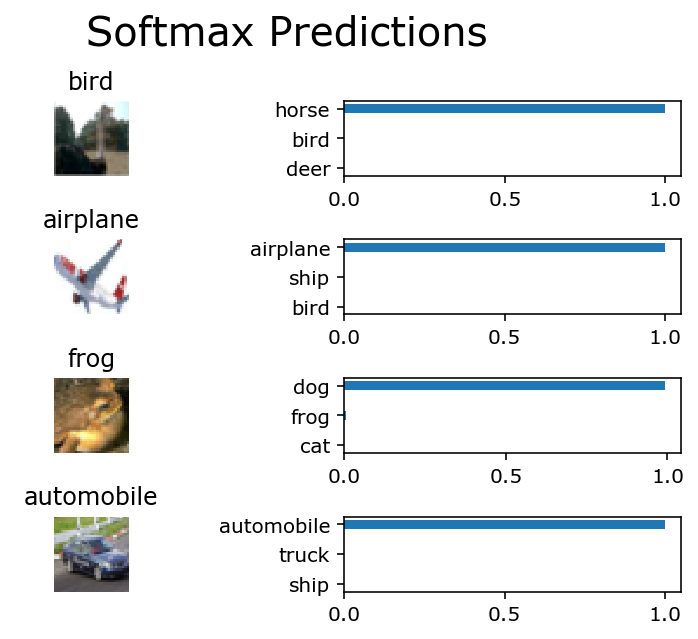

In [44]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for test_feature_batch, test_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()